# **aha-sleep-fe-cnn**
**sleep event** transforms - read event csv with converters
1. remove rows with NANs
2. transform SERIES_ID from hex string to int
3. transform timestamp -> uint32 minutes past 1970-01-01 (epoch time)
4. transform event from text to enum (NAN, **ONSET**, SLEEP, **WAKEUP**, AWAKE)
5. drop "step"
6. drop "night"
**series parquet** transforms - read series parquet with transforms
1. remove rows with NANs
2. transform SERIES_ID from hex string to int
3. transform timestamp -> uint32 minutes past 2017-01-01
4. transform zangle -> uint16 zangle (truncate)
5. transform enmo -> uint16 enmo * 1000
**feature label** generation
<br>generate AWAKE, ONSET, SLEEP, WAKEUP event labels for series - X series, Y labels
```
initialize counters, times, labels, limits
for each series id in series id list
    while series inx < series limits and
        event == series id and series == series id

        for next event
            if ONSET event
                set event onset time
            else if WAKEUP event
                set event wawkup time

        series time = time at series inx
        if series time > event wakeup time AND series time < event onset time
            series label == AWAKE
        else if series time > event onset time AND series time < event wakeup time
            series label == SLEEP
        else if series time > event wakeup time AND series time > event onset time
            if not last event
                ++event inx
                if previous series state == AWAKE
                    series label == ONSET
                else if previous series state == SLEEP
                    series label == WAKEUP
            else last event
                if previous series state === WAKEUP or AWAKE 
                    series label == AWAKE
                else if previous series state === ONSET or SLEEP 
                    series label == SLEEP
        else if series time == event onset time
            series label == ONSET
        else if series time == event wakeup time
            series label == WAKEUP
        ++ series inx

```
**TODO**
1. truncate last partial batch of series data
2. add reduction factor to test optimal series interval
**model** 
1. train CNN using X_train, Y labels
2. optimize learning rate
3. forecast
4. evaluate


 

In [1]:
!pip install icecream

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/utility-v2d/converter.py
/kaggle/input/utility-v2d/stopwatch.py
/kaggle/input/utility-v2d/stopwatch_unittest.py
/kaggle/input/utility-v2d/download_as_csv.py
/kaggle/input/utility-v2d/converter_unittest.py
/kaggle/input/utility-v2d/tuner.py
/kaggle/input/utility-v2d/series_label_unittest.py
/kaggle/input/utility-v2e/converter.py
/kaggle/input/utility-v2e/stopwatch.py
/kaggle/input/utility-v2e/stopwatch_unittest.py
/kaggle/input/utility-v2e/download_as_csv.py
/kaggle/input/utility-v2e/converter_unittest.py
/kaggle/input/utility-v2e/tuner.py
/kaggle/input/utility-v2e/series_label_unittest.py
/kaggle/input/utility-v2b/converter.py
/kaggle/input/utility-v2b/converter_unit_test.py
/kaggle/input/utility-v2b/tuner.py
/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pyarrow.parquet as pq
import tensorflow as tf

In [ ]:
# ####################################################################
# # import & (optionally) enable wandb modeling visualization 
# import wandb
# #wandb_enabled = True       # on -> interactive
# wandb_enabled = False     # off -> submission

# if wandb_enabled:
#     wandb.login()

In [4]:
from icecream import ic
ic(tf.__version__)

ic| tf.__version__: '2.12.0'


'2.12.0'

In [5]:
# import kaggle API key
!ls -l /kaggle/input/kaggle-json
!cp /kaggle/input/kaggle-json/kaggle.json /root/.kaggle
!ls -l /root/.kaggle
#!ls -l /root/.kaggle/

total 4
-rw-r--r-- 1 nobody nogroup 64 Dec  1 18:59 kaggle.json
-rw-r--r-- 1 root root 64 Dec  1 19:01 /root/.kaggle


In [6]:
# import python utility scripts
import sys
sys.path.append( "/kaggle/input/utility-v2f" )
from tuner import *
tuner
ic(tuner)
from converter import *
from converter_unittest import *
from stopwatch import *
from stopwatch_unittest import *
from series_label_unittest import *

ic| tuner: namespace(SERIES_ID_COLUMN='series_id',
                     NIGHT_COLUMN='night',
                     EVENT_COLUMN='event',
                     STEP_COLUMN='step',
                     TIME_COLUMN='timestamp',
                     NAN_TIME=0,
                     ANGLEZ_COLUMN='anglez',
                     ENMO_COLUMN='enmo',
                     ONSET_EVENT_LABEL='onset',
                     WAKEUP_EVENT_LABEL='wakeup',
                     NAN_EVENT=-1,
                     ONSET_EVENT=0,
                     SLEEP_EVENT=1,
                     WAKEUP_EVENT=2,
                     AWAKE_EVENT=3)


In [7]:
#stopwatch_unittest()
watch = stopwatch()
watch.start()
watch.stop()

timer duration -> 0.00m


In [8]:
converter_unittest()
#print(convert_to_seconds_after_midnight('2023-11-22T00:00:30-0400'))

ic| len(hex_string): 11


3866574267835
038441c925bb
1800
30
1534285560
None
25571426
None
1536209995
begin-end-trial event duration (seconds)->1924435
0
2
-1
2
-90
21


In [ ]:
# read raw event csv & print all rows
# train_events = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
# pd.set_option('display.max_rows', None)
# train_events

In [9]:
#event_converters = {tuner.SERIES_ID_COLUMN: hex_to_int, tuner.TIME_COLUMN: convert_to_seconds_after_midnight, tuner.EVENT_COLUMN: convert_event_enumeration}
event_converters = {tuner.SERIES_ID_COLUMN: hex_to_int, tuner.TIME_COLUMN: convert_to_seconds, tuner.EVENT_COLUMN: convert_event_enumeration}
#event_converters = {tuner.TIME_COLUMN: convert_to_minutes, tuner.EVENT_COLUMN: convert_event_enumeration}
# converters = {'timestamp': convert_to_minutes, 'event': convert_event_enumeration}
#converters = {'remove_rows_with_nan': {STEP_COLUMN: remove_rows_with_nan, TIME_COLUMN: remove_rows_with_nan}, TIME_COLUMN: convert_to_minutes, EVENT_COLUMN: convert_event_enumeration}


In [10]:
# read event csv
# train_events = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
train_event = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv', 
                          converters=event_converters)
print(f"raw # event rows - > {len(train_event)}")
# drop NAN rows
train_event = train_event.dropna(axis=0)
print(f"drop NAN # event rows - > {len(train_event)}")
# Re-index the DataFrame
train_event = train_event.reset_index(drop=True)

# drop night, step columns
train_event = train_event.drop(tuner.NIGHT_COLUMN, axis=1)
train_event = train_event.drop(tuner.STEP_COLUMN, axis=1)

ic(train_event[tuner.TIME_COLUMN].dtype)
train_event[tuner.TIME_COLUMN] = train_event[tuner.TIME_COLUMN].astype('uint32')
ic(train_event.iloc[0])
ic(train_event[tuner.TIME_COLUMN].dtype)

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 64)
train_event

ic| train_event[tuner.TIME_COLUMN].dtype: dtype('float64')
ic| train_event.iloc[0]: series_id    3866574267835
                         event                    0
                         timestamp       1534285560
                         Name: 0, dtype: int64
ic| train_event[tuner.TIME_COLUMN].dtype: dtype('uint32

raw # event rows - > 14508
drop NAN # event rows - > 9585


')


,series_id,event,timestamp
0,3866574267835,0,1534285560
1,3866574267835,2,1534315260
2,3866574267835,0,1534361820
3,3866574267835,2,1534398060
4,3866574267835,0,1534460580
...,...,...,...
9580,279894714452178,2,1504603560
9581,279894714452178,0,1504650600
9582,279894714452178,2,1504670820
9583,279894714452178,0,1504740900


In [11]:
# set series id lists
series_id_x = train_event.loc[0]['series_id']
ic(series_id_x)
series_id_list = train_event['series_id']
series_id_unique_list = train_event['series_id'].unique()
ic(len(series_id_list),len(series_id_unique_list))

ic| series_id_x: 3866574267835
ic| len(series_id_list): 9585, len(series_id_unique_list): 269


(9585, 269)

In [12]:
# filter train event df for selected series id
# train_event_filter = train_events.loc[(train_events['series_id'] == train_events.loc[0]['series_id'])]
train_event_x = train_event.loc[(train_event['series_id'] == series_id_x)]
ic(len(train_event_x))
pd.set_option('display.max_rows', None)
train_event_x
# test series start 1534260600

ic| len(train_event_x): 38


,series_id,event,timestamp
0,3866574267835,0,1534285560
1,3866574267835,2,1534315260
2,3866574267835,0,1534361820
3,3866574267835,2,1534398060
4,3866574267835,0,1534460580
5,3866574267835,2,1534482600
6,3866574267835,0,1534546800
7,3866574267835,2,1534574880
8,3866574267835,0,1534717080
9,3866574267835,2,1534749900


# Train Series
* metrics at 5 sec intervals
* ~86,400 per day (NAN rows will be deleted)


In [13]:
def series_parquet_to_pd(series_id_list, parquet_series_filename):
    #parquet_series = '/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet'
    #series_x = pq.read_table(parquet_series).to_pandas()
    series_id_hex = int_to_hex(series_id_x)
    ic(series_id_x)
    ic(series_id_hex)
    series_x = pq.read_table(parquet_series_filename,
                            filters=[[('series_id', '=', series_id_hex)],]).to_pandas()
    series_x = series_pd_xform(series_x)
    return series_x

In [14]:
def series_pd_xform(series_x):
    print(f"raw # series rows - > {len(series_x)}")
    # drop NAN rows
    series_x = series_x.dropna(axis=0)
    print(f"drop NAN # series rows - > {len(series_x)}")
    # drop step column
    series_x = series_x.drop(tuner.STEP_COLUMN, axis=1)
    print(series_x.columns)
  
    series_x[tuner.SERIES_ID_COLUMN] = series_x[tuner.SERIES_ID_COLUMN].apply(hex_to_int)
    #series_x[tuner.TIME_COLUMN] = series_x[tuner.TIME_COLUMN].apply(convert_to_seconds_after_midnight)
    series_x[tuner.TIME_COLUMN] = series_x[tuner.TIME_COLUMN].apply(convert_to_seconds)
    series_x[tuner.ANGLEZ_COLUMN] = series_x[tuner.ANGLEZ_COLUMN].apply(convert_zangle)
    series_x[tuner.ENMO_COLUMN] = series_x[tuner.ENMO_COLUMN].apply(convert_enmo)

    return series_x


In [15]:
def get_series_from_parquet(series_id_x, parquet_series_filename):
    watch = stopwatch()
    watch.start()
    ic(series_id_x)
    #parquet_series_filename = '/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet'
    series_x = series_parquet_to_pd(series_id_x, parquet_series_filename)
    watch.stop()
    pd.set_option('display.max_rows', 128)
    series_x   
    return series_x

In [16]:
parquet_series_filename = '/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet'
train_series_x = get_series_from_parquet(series_id_x, parquet_series_filename)

ic| series_id_x: 3866574267835
ic| len(hex_string): 11
ic| series_id_x: 3866574267835
ic| series_id_hex: '038441c925bb'


raw # series rows - > 389880
drop NAN # series rows - > 389880
Index(['series_id', 'timestamp', 'anglez', 'enmo'], dtype='object')
timer duration -> 0.57m


In [17]:
parquet_series_filename = '/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet'
test_series_x = get_series_from_parquet(series_id_x, parquet_series_filename)

ic| series_id_x: 3866574267835
ic| len(hex_string): 11
ic| series_id_x: 3866574267835
ic| series_id_hex: '038441c925bb'


raw # series rows - > 150
drop NAN # series rows - > 150
Index(['series_id', 'timestamp', 'anglez', 'enmo'], dtype='object')
timer duration -> 0.00m


In [18]:
ic(test_series_x)

ic| test_series_x:          series_id   timestamp  anglez  enmo
                   0    3866574267835  1534260600       2    21
                   1    3866574267835  1534260605       2    21
                   2    3866574267835  1534260610       2    21
                   3    3866574267835  1534260615       2    21
                   4    3866574267835  1534260620       2    21
                   ..             ...         ...     ...   ...
                   145  3866574267835  1534261325     -79    13
                   146  3866574267835  1534261330     -80    13
                   147  3866574267835  1534261335     -80    13
                   148  3866574267835  1534261340     -80    13
                   149  3866574267835  1534261345     -80    13
                   
                   [150 rows x 4 columns]


,series_id,timestamp,anglez,enmo
0,3866574267835,1534260600,2,21
1,3866574267835,1534260605,2,21
2,3866574267835,1534260610,2,21
3,3866574267835,1534260615,2,21
4,3866574267835,1534260620,2,21
...,...,...,...,...
145,3866574267835,1534261325,-79,13
146,3866574267835,1534261330,-80,13
147,3866574267835,1534261335,-80,13
148,3866574267835,1534261340,-80,13


In [ ]:
# # train series
# watch = stopwatch()
# watch.start()
# ic(series_id_x)
# parquet_series_filename = '/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet'
# train_series_x = series_parquet_to_pd(series_id_x, parquet_series_filename)
# watch.stop()
# pd.set_option('display.max_rows', 128)
# train_series_x

In [19]:
# trace event & series related info
trace_event_series = False
def trace_event_series_snapshot(event_inx, event_onset_time, event_wakeup_time,\
                              series_inx, series_time, series_label):
    if trace_event_series:
        ic(event_inx, event_onset_time, event_wakeup_time)
        ic(series_inx-1, series_time, series_label[series_inx-1])
        ic(series_inx, series_time, series_label[series_inx])


In [20]:
def label_series(series_id_list,train_event,series_x):
    event_inx = 0
    series_inx = 0
    event_onset_time = 0
    event_wakeup_time = 0
    event_detected = False
    ic(event_inx, event_onset_time, event_wakeup_time)
    INTERVAL = 5 # 5 second intervals
    series_label = []

    # series_id 038441c925bb
    # train_event_filter_limit = 38
    # train_series_x_limit = 389879

    train_event_filter_limit = len(train_event)
    series_x_limit = len(series_x)
    ic(train_event_filter_limit, series_x_limit)

    #df.at[index, 'col_name'] = x

    ic(series_id_list)
    for series_id in series_id_list:
        ic(series_id)
        while series_inx < series_x_limit and \
            train_event.at[event_inx, tuner.SERIES_ID_COLUMN] == series_id and \
            series_x.at[series_inx, tuner.SERIES_ID_COLUMN] == series_id:

            if not event_detected:
                if train_event.at[event_inx, tuner.EVENT_COLUMN] == tuner.ONSET_EVENT:
                    event_onset_time = train_event.at[event_inx, tuner.TIME_COLUMN]
                    event_detected = True
                elif train_event.at[event_inx, tuner.EVENT_COLUMN] == tuner.WAKEUP_EVENT:
                    event_wakeup_time = train_event.at[event_inx, tuner.TIME_COLUMN]
                    event_detected = True
                #ic(event_inx, event_onset_time, event_wakeup_time)

            series_time = series_x.at[series_inx, tuner.TIME_COLUMN]
            #ic(series_inx, series_time)
            if series_time > event_wakeup_time and series_time < event_onset_time:
                series_label.append(tuner.AWAKE_EVENT)
                
            elif series_time > event_onset_time and series_time < event_wakeup_time:
                series_label.append(tuner.SLEEP_EVENT)
                
            elif series_time > event_wakeup_time and series_time > event_onset_time:
                # prevent event_inx advancing past EOF
                if event_inx + 1 < len(train_event):
                    event_inx = event_inx + 1
                    if series_label[series_inx-1] == tuner.AWAKE_EVENT:
                        series_label.append(tuner.ONSET_EVENT)
                    elif series_label[series_inx-1] == tuner.SLEEP_EVENT:
                        series_label.append(tuner.WAKEUP_EVENT)
                    trace_event_series_snapshot(event_inx, event_onset_time, event_wakeup_time,\
                                               series_inx, series_time, series_label)
                # last event at EOF
                else:
                    if series_label[series_inx-1] == tuner.WAKEUP_EVENT or\
                    series_label[series_inx-1] == tuner.AWAKE_EVENT: 
                        series_label.append(tuner.AWAKE_EVENT)
                    elif series_label[series_inx-1] == tuner.ONSET_EVENT or\
                    series_label[series_inx-1] == tuner.SLEEP_EVENT:
                        series_label.append(tuner.SLEEP_EVENT)

                event_detected = False

                
            elif series_time == event_onset_time:
                series_label.append(tuner.ONSET_EVENT)
                # prevent event_inx advancing past EOF
                if event_inx + 1 < len(train_event):
                    event_inx = event_inx + 1
                event_detected = False

                trace_event_series_snapshot(event_inx, event_onset_time, event_wakeup_time,\
                                           series_inx, series_time, series_label)
                
            elif series_time == event_wakeup_time: 
                series_label.append(tuner.WAKEUP_EVENT)
                # prevent event_inx advancing past EOF
                if event_inx + 1 < len(train_event):
                    event_inx = event_inx + 1
                event_detected = False

                trace_event_series_snapshot(event_inx, event_onset_time, event_wakeup_time,\
                                           series_inx, series_time, series_label)

            series_inx = series_inx + 1
    return series_label    


In [21]:
def gen_series_label(series_id_list, train_event_x, series_x):
    # label series
    watch = stopwatch()
    watch.start()
    series_id_list = [3866574267835]
    series_label_list = label_series(series_id_list, train_event_x, series_x)
    watch.stop()
    
    series_label_array = np.array(series_label_list)
    series_label = pd.DataFrame(series_label_array)
    return series_label


In [22]:
# generate train series labels
train_series_label = gen_series_label(series_id_list, train_event_x, train_series_x)
ic(train_series_label)

ic| event_inx: 0, event_onset_time: 0, event_wakeup_time: 0
ic| train_event_filter_limit: 38, series_x_limit: 389880
ic| series_id_list: [3866574267835]
ic| series_id: 3866574267835
ic| train_series_label:         0
                        0       3
                        1       3
                        2       3
                        3       3
                        4       3
                        ...    ..
                        389875  3
                        389876  3
                        389877  3
                        389878  3
                        389879  3
                        
                        [389880 rows x 1 columns]


timer duration -> 0.25m


,0
0,3
1,3
2,3
3,3
4,3
...,...
389875,3
389876,3
389877,3
389878,3


In [23]:
# write series label lists to disk
!pwd
train_series_label.to_csv('/kaggle/working/train_series_label.csv', index=False)
#test_series_label.to_csv('/kaggle/working/test_series_label.csv', index=False)
!ls -l
!pwd

/kaggle/working
total 764
-rw-r--r-- 1 root root 779762 Dec  1 19:04 train_series_label.csv
/kaggle/working


In [24]:
# try reading previously generated label lists from disk
def try_read_series_label(series_label_filename):
    # if series labels exist & regen off
    if os.path.exists(series_label_filename):
        # read existing series labels
        series_label_list = pd.read_csv(series_label_filename)
        ic(series_label_filename, len(series_label_list))
        return series_label_list
    else:
        return None

In [25]:
# try reading previously generated label lists from disk
train_series_label_filename = '/kaggle/working/train_series_label.csv'
train_series_label_list = try_read_series_label(train_series_label_filename)

# test_series_label_filename = '/kaggle/working/test_series_label.csv'
# test_series_label_list = try_read_series_label(test_series_label_filename)

ic| series_label_filename: '/kaggle/working/train_series_label.csv'
    len(series_label_list): 389880


In [26]:
def print_series_type(series_x, series_label):
    print(series_x[tuner.SERIES_ID_COLUMN].dtype)
    #print(train_series_x[tuner.STEP_COLUMN].dtype)
    print(series_x[tuner.TIME_COLUMN].dtype)
    print(series_x[tuner.ANGLEZ_COLUMN].dtype)
    print(series_x[tuner.ENMO_COLUMN].dtype)

    print(series_label[0].dtype)


In [27]:
print_series_type(train_series_x, train_series_label)
#print_series_type(test_series_x, test_series_label)

int64
int32
int16
uint16
int64


In [28]:
# plot series labels & event indicators
def plot_series(x, y, format=".", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

ic| time: array([1534260600, 1534260605, 1534260610, ..., 1536209985, 1536209990,
                 1536209995], dtype=int32)
ic| series: array([[3],
                   [3],
                   [3],
                   ...,
                   [3],
                   [3],
                   [3]])


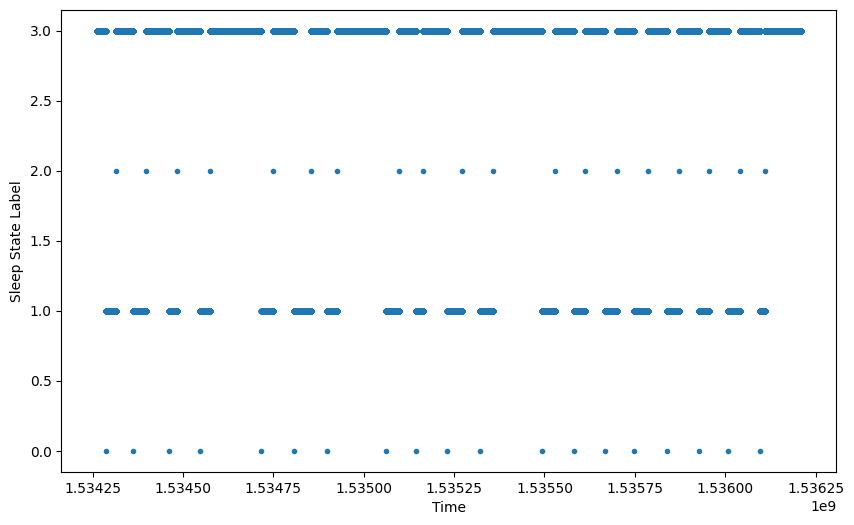

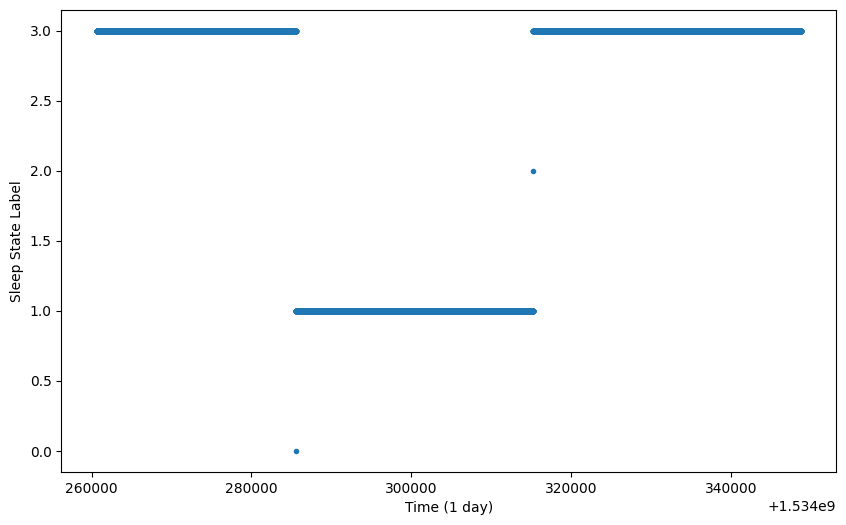

In [29]:
# Convert lists to numpy arrays
time = train_series_x[tuner.TIME_COLUMN].to_numpy()
ic(time)
series = train_series_label.to_numpy()
ic(series)
# Preview the data
# all days
plot_series(time, series, title="Train Series", xlabel='Time', ylabel='Sleep State Label')
# one day
plot_series(time, series, title="Train Series", xlabel='Time (1 day)', ylabel='Sleep State Label', start=0, end=17640)

In [ ]:
# # Convert lists to numpy arrays
# time = test_series_x[tuner.TIME_COLUMN].to_numpy()
# #ic(time)
# series = test_series_label.to_numpy()
# #ic(series)
# # Preview the data
# # all days
# plot_series(time, series, title="Test Series", xlabel='Time', ylabel='Sleep State Label')
# # one day
# plot_series(time, series, title="Test Series", xlabel='Time (1 day)', ylabel='Sleep State Label', start=0, end=17640)

ic| time: array([1534260600, 1534260605, 1534260610, ..., 1536209985, 1536209990,
                 1536209995], dtype=int32)
ic| series: array([21, 21, 21, ..., 11, 11, 12], dtype=uint16)


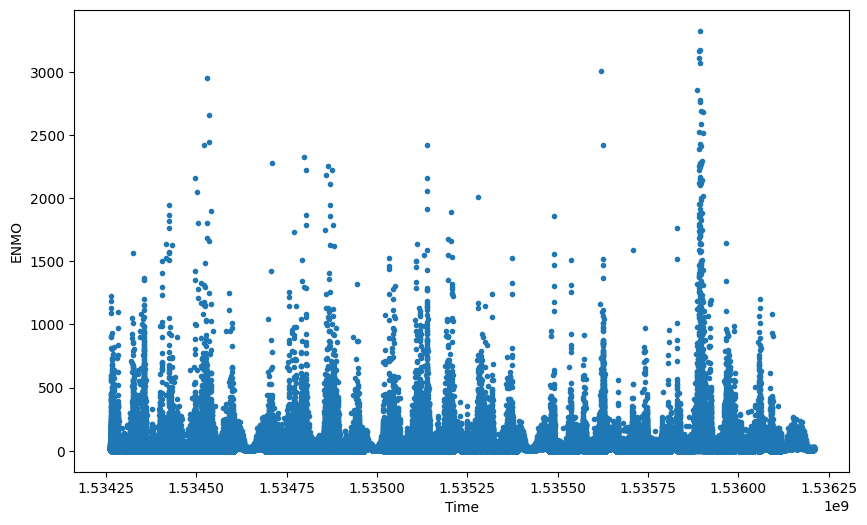

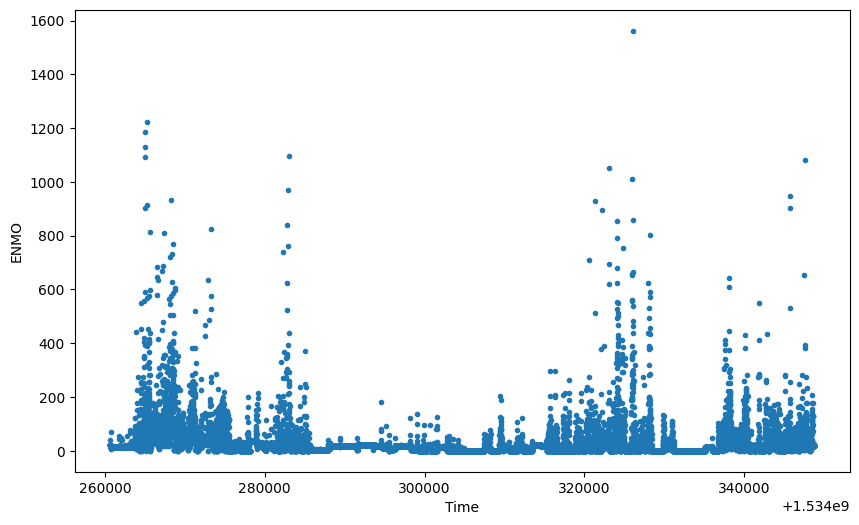

In [30]:
# Convert lists to numpy arrays
time = train_series_x[tuner.TIME_COLUMN].to_numpy()
ic(time)
series = train_series_x[tuner.ENMO_COLUMN].to_numpy()
ic(series)
# Preview the data
plot_series(time, series, title="Train Series", xlabel='Time', ylabel='ENMO')
plot_series(time, series, title="Train Series", xlabel='Time', ylabel='ENMO', start=0, end=17640)


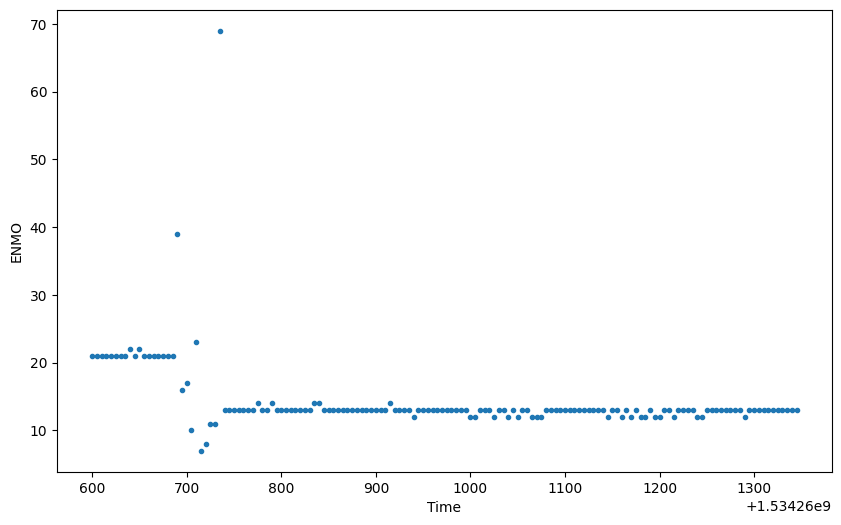

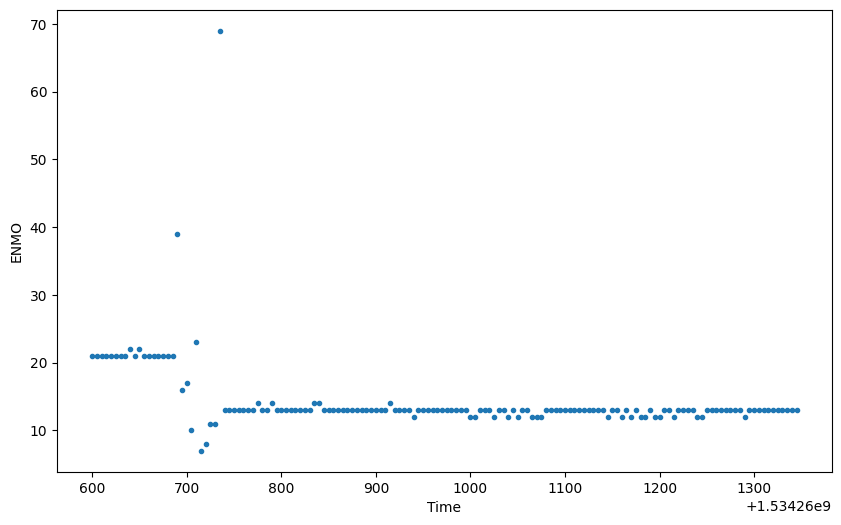

In [31]:
# Convert lists to numpy arrays
time = test_series_x[tuner.TIME_COLUMN].to_numpy()
#ic(time)
series = test_series_x[tuner.ENMO_COLUMN].to_numpy()
#ic(series)
# Preview the data
plot_series(time, series, title="Test Series", xlabel='Time', ylabel='ENMO')
plot_series(time, series, title="Test Series", xlabel='Time', ylabel='ENMO', start=0, end=17640)


ic| time: array([1534260600, 1534260605, 1534260610, ..., 1536209985, 1536209990,
                 1536209995], dtype=int32)
ic| series: array([  2,   2,   2, ..., -27, -28, -28], dtype=int16)


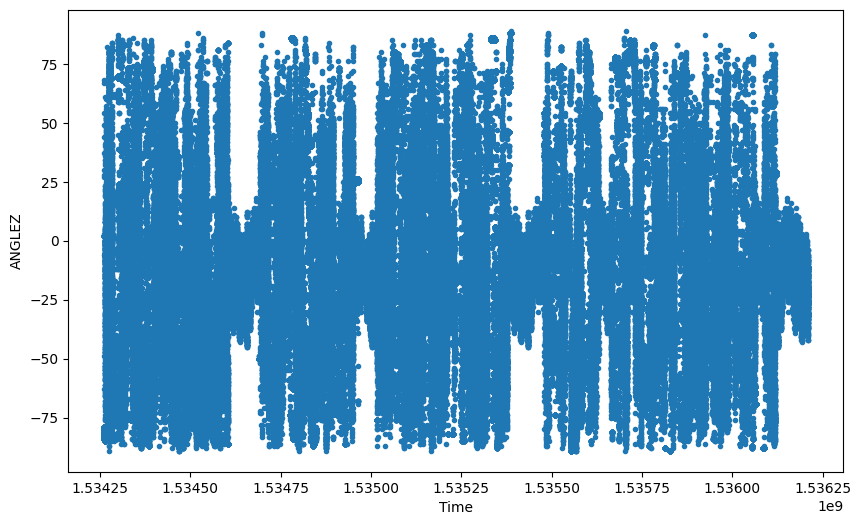

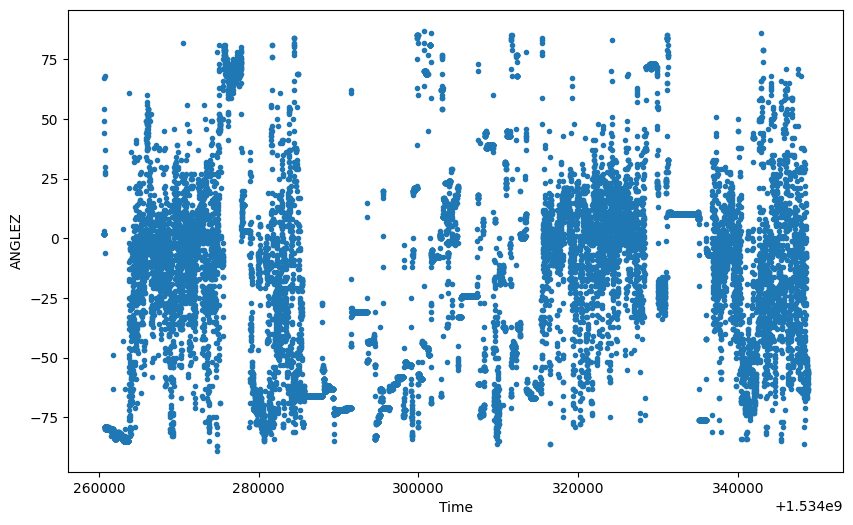

In [32]:
# Convert lists to numpy arrays
time = train_series_x[tuner.TIME_COLUMN].to_numpy()
ic(time)
series = train_series_x[tuner.ANGLEZ_COLUMN].to_numpy()
ic(series)
# Preview the data
plot_series(time, series, title="Train Series", xlabel='Time', ylabel='ANGLEZ')
plot_series(time, series, title="Train Series", xlabel='Time', ylabel='ANGLEZ', start=0, end=17640)

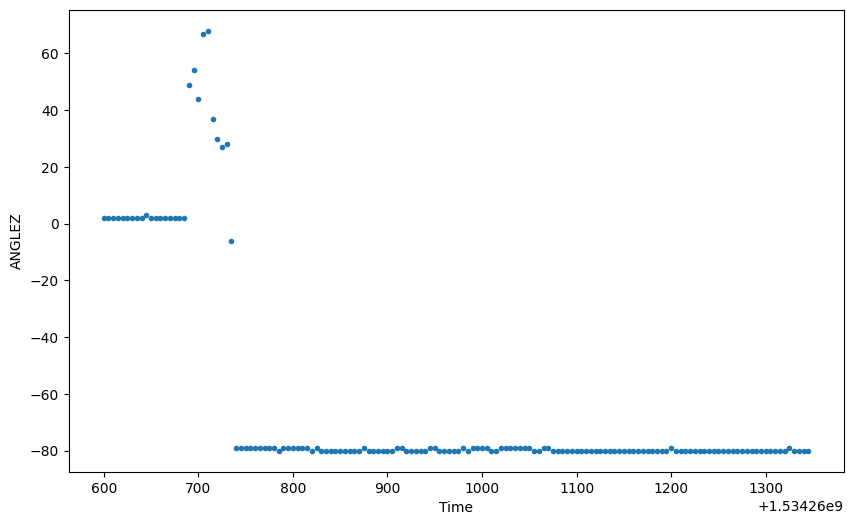

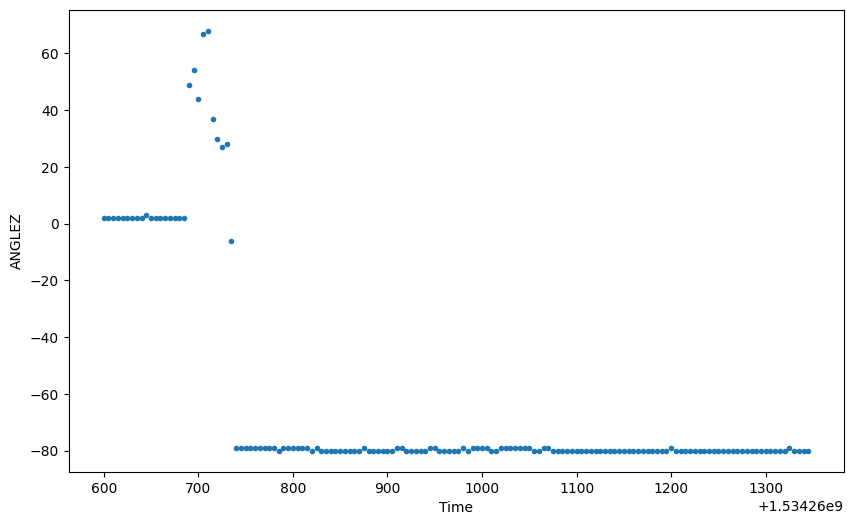

In [33]:
# Convert lists to numpy arrays
time = test_series_x[tuner.TIME_COLUMN].to_numpy()
#ic(time)
series = test_series_x[tuner.ANGLEZ_COLUMN].to_numpy()
#ic(series)
# Preview the data
plot_series(time, series, title="Test Series", xlabel='Time', ylabel='ANGLEZ')
plot_series(time, series, title="Test Series", xlabel='Time', ylabel='ANGLEZ', start=0, end=17640)

In [34]:
metric_interval_secs = 5
metric_count_per_min = np.rint((60 / metric_interval_secs)).astype(int)
metric_count_per_hour = np.rint((60 * metric_count_per_min)).astype(int)
metric_count_per_day = np.rint((metric_count_per_hour * 24)).astype(int)
ic(metric_count_per_day, metric_count_per_hour, metric_count_per_min, metric_interval_secs)


ic| metric_count_per_day: 17280
    metric_count_per_hour: 720
    metric_count_per_min: 12
    metric_interval_secs: 5


(17280, 720, 12, 5)

In [35]:
# x_train
train_series_x_trim = train_series_x.drop(tuner.SERIES_ID_COLUMN, axis=1)
ic(train_series_x_trim.head())
x_train = train_series_x_trim.to_numpy()
ic(x_train.shape)
#x_train

ic| train_series_x_trim.head():     timestamp  anglez  enmo
                                0  1534260600       2    21
                                1  1534260605       2    21
                                2  1534260610       2    21
                                3  1534260615       2    21
                                4  1534260620       2    21
ic| x_train.shape: (389880, 3)


(389880, 3)

In [36]:
# x_test
test_series_x_trim = test_series_x.drop(tuner.SERIES_ID_COLUMN, axis=1)
ic(test_series_x_trim.head())
x_test = test_series_x_trim.to_numpy()
ic(x_test.shape)
#x_train

ic| test_series_x_trim.head():     timestamp  anglez  enmo
                               0  1534260600       2    21
                               1  1534260605       2    21
                               2  1534260610       2    21
                               3  1534260615       2    21
                               4  1534260620       2    21
ic| x_test.shape: (150, 3)


(150, 3)

In [ ]:
# step = []
# for i in range(x_train.shape[0]):
#     step.append(metric_count_per_day)
# x_train_steps = np.array(step)
# ic(x_train_steps.shape)
# ic(x_train_steps)

In [ ]:
# x_train_save = x_train

In [ ]:
# # input -> x_train(:,3) -> # in series, time/enmo/anglez
# #    ic| x_train.shape: (389880, 3)
# # reshape x_train to {batch_size, time, enmo/anglez}
# # return x_train(:,1,2) -> # in series, time, enmo/anglez
# #    ic| target_array.shape: (389880, 1, 2)
# x_train = x_train_save
# ic(x_train.shape)
# ic(x_train.shape[0])

# cat_array = np.concatenate((x_train_steps[:, np.newaxis], x_train), axis=1)
# ic(cat_array.shape)
# # Reshape the concatenated nparray to (# rows, 1, 3)
# target_array = cat_array[:, :3].reshape((x_train.shape[0], 1, 3))
# #target_array = cat_array.reshape((cat_array.shape[0], 1, 3))
# #target_array = x_train[:, :2].reshape((x_train.shape[0], 1, 2))

# # Print the shape of the desired nparray
# ic(target_array.shape)
# x_train = target_array

In [37]:
#series_label_nparray = np.array(series_label_array)
series_label_nparray = np.array(train_series_label)
ic(series_label_nparray.shape)
y_train = series_label_nparray

ic| series_label_nparray.shape: (389880, 1)


In [38]:
ic(x_train.shape)
#y_train = series_label.to_numpy()
ic(y_train.shape)
y_train
ic(x_test.shape)

ic| x_train.shape: (389880, 3)
ic| y_train.shape: (389880, 1)
ic| x_test.shape: (150, 3)


(150, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input shape
# Assuming num_samples=#samples, num_features=number_of_features=3 (metric1, metric2, metric3)
num_samples = x_train.shape[0]
num_features = 3
input_shape = (num_samples, num_features, 3)  

# Define the model architecture
model = tf.keras.Sequential([
    layers.Flatten(),

    # Reshape the input to fit the LSTM layer
    layers.Reshape((num_samples, 1, num_features)),

    # Two LSTM layers to extract temporal features
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),

    # Flatten the output of the LSTM layers
    layers.Flatten(),

    # Dense layer with softmax activation for state prediction
    layers.Dense(4, activation='softmax')
])



In [ ]:
# Assuming the expected output shape is (None, 1)
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((389880, 1, 3)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')  # Adjust activation function based on task
])


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10)  # Replace x_train and y_train with your actual training data

# Make predictions on new data
#new_data = np.array([[[1.2, 3.4, 5.6], [2.5, 4.7, 7.2], [3.1, 5.2, 8.8]]])  # Sample data with shape (1, timesteps, num_features)
predictions = model.predict(y_test)
print(predictions)  # Output will be probabilities for each of the 4 states at each time step


# ***various model types***

In [ ]:
#########################################################################

In [ ]:
from dataclasses import dataclass
@dataclass
class G:
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(train_series_x, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [ ]:
def create_uncompiled_model():
    # Build the Model
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                          strides=1,
                          activation="relu",
                          padding='causal',
                          input_shape=[G.WINDOW_SIZE, 2]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    # Print the model summary 
    model.summary()

    return model

In [ ]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

In [ ]:
def create_c4w4_model():

    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                          strides=1,
                          activation="relu",
                          padding='causal',
                          input_shape=[1, 3]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
        tf.keras.layers.Dense(4)
    ])

    model.summary()

    return model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Create a CNN model
model = create_c4w4_model()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the data
model.fit(x_train, y_train, epochs=10)

# Evaluate the model on the test data
#model.evaluate(x_test, y_test)

In [ ]:
import tensorflow as tf

# Define the CNN architecture
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()

        # Define the convolutional layers
#         self.conv1 = tf.keras.layers.Conv1D(32, 3, activation='relu')
#         self.conv2 = tf.keras.layers.Conv1D(64, 3, activation='relu')

        self.conv1 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')

        # Define the pooling layers
        self.pool1 = tf.keras.layers.MaxPooling1D(2)
        self.pool2 = tf.keras.layers.MaxPooling1D(2)

        # Define the fully connected layers
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(4, activation='softmax')

    def call(self, inputs):
        # Pass the inputs through the convolutional and pooling layers
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)

        # Flatten the output of the pooling layer
        x = tf.keras.layers.Flatten()(x)

        # Pass the flattened output through the fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [ ]:
# Create a CNN model
model = CNN()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reshape the input to the Conv1D layer to have 3 dimensions
#x_train = tf.expand_dims(x_train, axis=2)
#x_test = tf.expand_dims(x_test, axis=2)

# Train the model on the data
model.fit(x_train, y_train, epochs=10)

# Evaluate the model on the test data
#model.evaluate(x_test, y_test)

In [ ]:
import tensorflow as tf

# Define the RNN model
class RNN(tf.keras.Model):
    def __init__(self):
        super(RNN, self).__init__()

        # Define the recurrent layer
        self.rnn = tf.keras.layers.LSTM(64, return_sequences=True)

        # Define the fully connected layer
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')

        # Define the output layer
        self.fc2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        # Pass the inputs through the recurrent layer
        x = self.rnn(inputs)

        # Flatten the output of the recurrent layer
        x = tf.keras.layers.Flatten()(x)

        # Pass the flattened output through the fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an RNN model
model = RNN()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model on the data
model.fit(x_train, y_train, epochs=10)

# Evaluate the model on the test data
# model.evaluate(x_test, y_test)

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [ ]:
import tensorflow as tf

# Define the input layer
inputs = tf.keras.layers.Input(shape=(389880, 3))

# Define the convolutional layer
conv1 = tf.keras.layers.Conv1D(32, 3, activation='relu')(inputs)

# Define the pooling layer
pool1 = tf.keras.layers.MaxPooling1D(2)(conv1)

# Flatten the output of the pooling layer
flatten = tf.keras.layers.Flatten()(pool1)

# Define the fully connected layer
fc1 = tf.keras.layers.Dense(1, activation='relu')(flatten)

# Define the output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(fc1)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model on the data
model.fit(x_train, y_train, epochs=10)

# Evaluate the model on the test data
# model.evaluate(x_test, y_test)

In [ ]:
import tensorflow as tf

class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()

        # Define the convolutional layer
        self.conv1 = tf.keras.layers.Conv1D(32, 3, activation='relu')

        # Define the pooling layer
        self.pool1 = tf.keras.layers.MaxPooling1D(2)

        # Define the fully connected layer
        self.fc1 = tf.keras.layers.Dense(1, activation='relu')

    def call(self, inputs):
        # Pass the inputs through the convolutional and pooling layers
        x = self.conv1(inputs)
        x = self.pool1(x)

        # Flatten the output of the pooling layer
        x = tf.keras.layers.Flatten()(x)

        # Pass the flattened output through the fully connected layer
        x = self.fc1(x)

        return x

# Create a CNN model
model = CNN()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the data
model.fit(x_train, y_train, epochs=10)

model.summary()

# Evaluate the model on the test data
# model.evaluate(x_test, y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, Conv1D
tf.random.set_seed(0)

def get_model_cnn_lstm(history, future):
    model = Sequential()
    #model.add(tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2])))
    model.add(tf.keras.Input(shape=(x_train.shape[0], x_train.shape[1])))
    model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=5, activation='relu'))
    model.add(LSTM(6, return_sequences=True, activation='relu'))
    model.add(LSTM(6, return_sequences=False, activation='relu'))
    model.add(Dense(future))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

history = 12 #last values used by model
future = 6 #predict future values

model_cnnlstm = get_model_cnn_lstm(history, future)
model_cnnlstm.summary()

In [ ]:
hist_cnn_lstm = model_cnnlstm.fit(x_train_expanded, y_train, epochs=10)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

n_samples = x_train.shape[0]
ic(n_samples)
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(4))

model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train,epochs=10)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(4, activation='softmax')
])



In [ ]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
# Train the model
history = model.fit(x_train,epochs=10)

In [ ]:
import tensorflow as tf

class CNN(tf.keras.Model):
    def __init__(self, n_metrics, n_filters=32, kernel_size=3, n_classes=4):
        super(CNN, self).__init__()

        # Define the dense layers
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(512, activation='relu')

        # Define the fully connected layers
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(n_classes, activation='softmax')

    def call(self, inputs):
        # Pass the inputs through the dense layers
        x = self.dense1(inputs)
        x = self.dense2(x)

        # Flatten the output of the dense layer
        x = tf.keras.layers.Flatten()(x)

        # Pass the flattened output through the fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create a CNN model
n_metrics = 3
model = CNN(n_metrics)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the data
model.fit(x_train, y_train, epochs=10)

# Evaluate the model on the test data
# model.evaluate(x_test, y_test)

In [ ]:
import tensorflow as tf

class CNN(tf.keras.Model):
    #def __init__(self, n_metrics, n_filters=32, kernel_size=3, n_classes=4):
    def __init__(self, n_metrics, n_filters=32, kernel_size=3, n_classes=4):
        super(CNN, self).__init__()

        # Define the convolutional layers
        self.conv1 = tf.keras.layers.Conv1D(n_filters, kernel_size, activation='relu')

        # Define the pooling layers
        self.pool1 = tf.keras.layers.MaxPooling1D(2)

        # Define the fully connected layers
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(n_classes, activation='softmax')

    def call(self, inputs):
        # Pass the inputs through the convolutional and pooling layers
        x = self.conv1(inputs)
        x = self.pool1(x)

        # Flatten the output of the pooling layer
        x = tf.keras.layers.Flatten()(x)

        # Pass the flattened output through the fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [ ]:
# Create a CNN model
n_metrics = 3
model = CNN(n_metrics)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the data
model.fit(x_train, y_train, epochs=10)

# # Evaluate the model on the test data
# model.evaluate(x_test, y_test)


In [ ]:
# Create a NumPy array of shape (n_samples, 3)
#x_train_dummy = np.array([[1, 2, 3], [4, 5, 6]])
x_train_dummy = x_train

# Expand the third dimension of the NumPy array
x_train_expanded = tf.expand_dims(x_train_dummy, axis=-1)

# Create a Conv1D layer
conv1d_layer = tf.keras.layers.Conv1D(32, (3,), activation='relu')

# Pass the `x_train_expanded` NumPy array to the Conv1D layer
output = conv1d_layer(x_train_expanded)

# Print the shape of the output tensor
print(output.shape)

In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[None, 3, 1, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(4, activation='softmax')
])

 # Print the model summary 
model.summary()

# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model on the data
# model.fit(x_train, y_train, epochs=10)
